RMI Visualization Module
===============================================================================
This module will generate visualizations in order to illustrate the accuracy
of our implemented rmi structure.

In [2]:
import sys, os

# Allow for absolute imported paths
project_root = project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.path.abspath
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import numpy as np
import time
from src.indexes.btree_optimized import BTreeOptimized as BTree
from src.indexes.learned_index_optimized import LearnedIndexOptimized as LearnedIndex
from src.indexes.linear_index_adaptive import LinearIndexAdaptive
from src.indexes.rmi import RecursiveModelIndex
from src.utils.data_loader import DatasetGenerator

In [9]:
# Same size for the datasets to keep consistency
DATASET_SIZE = 100_000

## This section will be regarding the uniform dataset

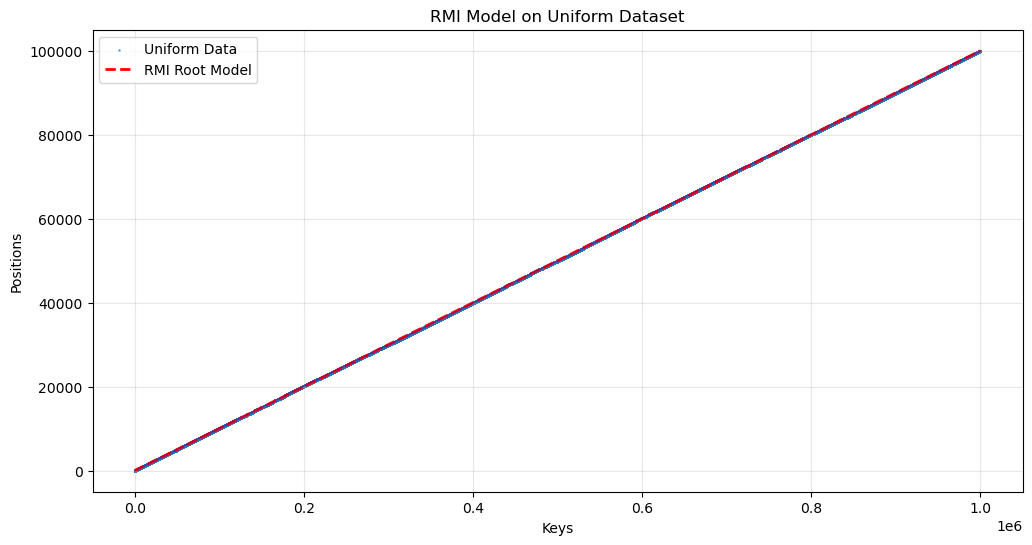

In [10]:


def plot_uniform():
    # Get the data from our loader
    data_loader_uniform = DatasetGenerator.generate_uniform(DATASET_SIZE)

    # Build our learned index that has been created
    rmi_uniform = RecursiveModelIndex()
    rmi_uniform.build_from_sorted_array(data_loader_uniform)

    # Create the base plot with the dataset
    plt.figure(figsize=(12, 6))
    plt.scatter(data_loader_uniform, np.arange(len(data_loader_uniform)), s=1, label='Uniform Data', alpha=0.5)

    # Now, we can plot the RMI predictions
    # First, we need to plot the first (root) model
    root_predictions = rmi_uniform.a0 * data_loader_uniform + rmi_uniform.b0
    plt.plot(data_loader_uniform, root_predictions, color='red', label='RMI Root Model', linewidth=2, linestyle='--')

    # Now, we can plot the leaf models
    for i in range(rmi_uniform.fanout):
        start = int(rmi_uniform.seg_start[i])
        end = int(rmi_uniform.seg_end[i])
        if end <= start:
            continue
        
        # Get keys in this segment
        seg_keys = data_loader_uniform[start:end]
        seg_predictions = rmi_uniform.seg_a[i] * seg_keys + rmi_uniform.seg_b[i]
        
        # Plot leaf model for this segment
        plt.plot(seg_keys, seg_predictions, color='purple', linewidth=1, alpha=0.6)

    plt.title('RMI Model on Uniform Dataset')
    plt.xlabel('Keys')
    plt.ylabel('Positions')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_uniform()

### Results from the uniform dataset:

### As we can see, the RMI is able to closely follow the distribution of the data, providing accurate position predictions.

## This section will be regarding the sequential dataset

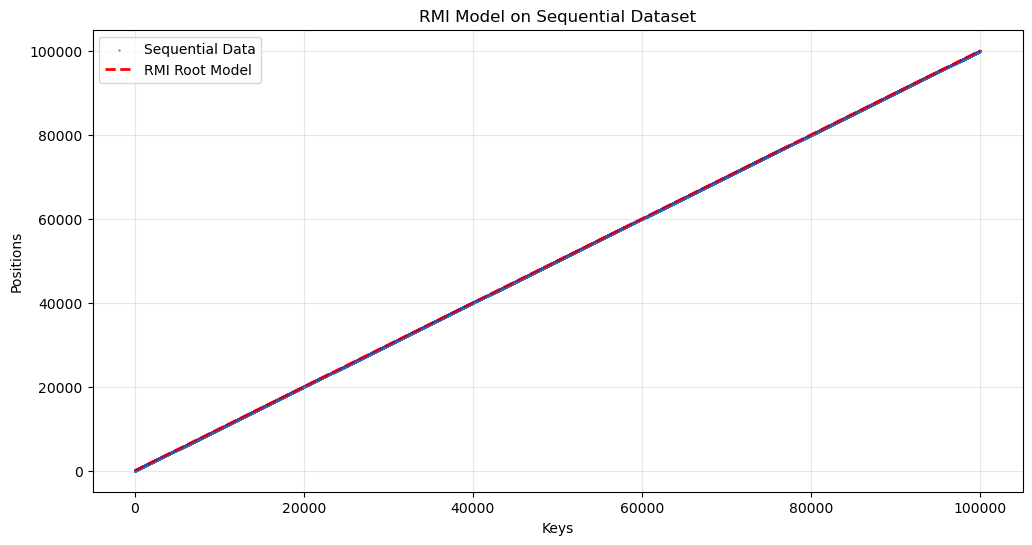

In [11]:
def plot_sequential():
    # Get the data from our loader
    data_loader_sequential = DatasetGenerator.generate_sequential(DATASET_SIZE)

    # Build our learned index that has been created
    rmi_sequential = RecursiveModelIndex()
    rmi_sequential.build_from_sorted_array(data_loader_sequential)

    # Create the base plot with the dataset
    plt.figure(figsize=(12, 6))
    plt.scatter(data_loader_sequential, np.arange(len(data_loader_sequential)), s=1, label='Sequential Data', alpha=0.5)

    # Now, we can plot the RMI predictions
    # First, we need to plot the first (root) model
    root_predictions = rmi_sequential.a0 * data_loader_sequential + rmi_sequential.b0
    plt.plot(data_loader_sequential, root_predictions, color='red', label='RMI Root Model', linewidth=2, linestyle='--')

    # Now, we can plot the leaf models
    for i in range(rmi_sequential.fanout):
        start = int(rmi_sequential.seg_start[i])
        end = int(rmi_sequential.seg_end[i])
        if end <= start:
            continue
        
        # Get keys in this segment
        seg_keys = data_loader_sequential[start:end]
        seg_predictions = rmi_sequential.seg_a[i] * seg_keys + rmi_sequential.seg_b[i]
        
        # Plot leaf model for this segment
        plt.plot(seg_keys, seg_predictions, color='purple', linewidth=1, alpha=0.6)

    plt.title('RMI Model on Sequential Dataset')
    plt.xlabel('Keys')
    plt.ylabel('Positions')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_sequential()

### Results from the sequential dataset:

### As we can see, the RMI is also able to closely follow the distribution of the sequential data, providing accurate position predictions.

## This section will be regarding the mixed dataset

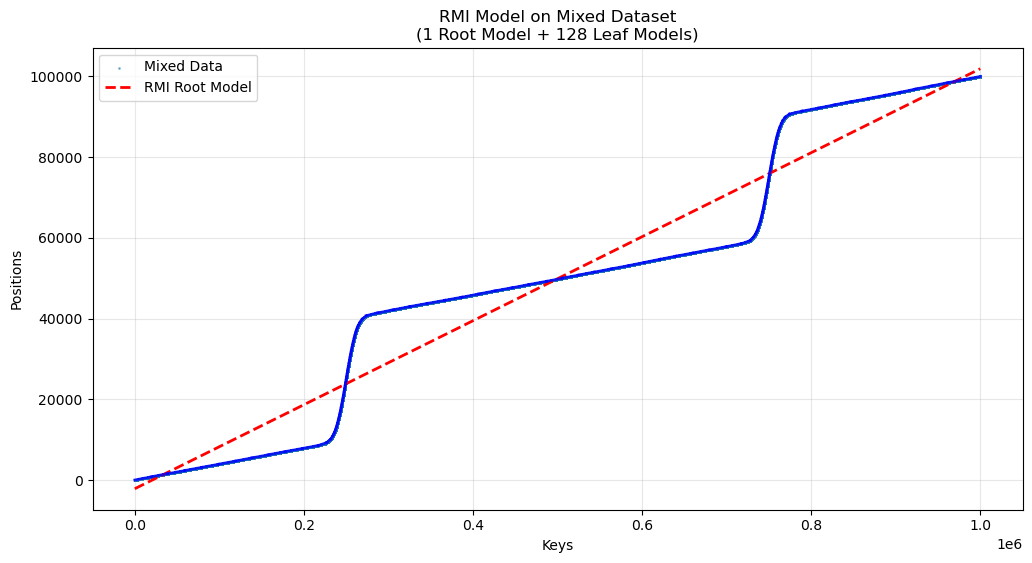

In [12]:
def plot_mixed():
    # Get the data from our loader
    data_loader_mixed = DatasetGenerator.generate_mixed(DATASET_SIZE)

    # Build our learned index that has been created
    rmi_mixed = RecursiveModelIndex()
    rmi_mixed.build_from_sorted_array(data_loader_mixed)

    # Create the base plot with the dataset
    plt.figure(figsize=(12, 6))
    plt.scatter(data_loader_mixed, np.arange(len(data_loader_mixed)), s=1, label='Mixed Data', alpha=0.5)

    # Now, we can plot the RMI predictions
    # First, we need to plot the first (root) model
    root_predictions = rmi_mixed.a0 * data_loader_mixed + rmi_mixed.b0
    plt.plot(data_loader_mixed, root_predictions, color='red', label='RMI Root Model', linewidth=2, linestyle='--')

    # Now, we can plot the leaf models
    for i in range(rmi_mixed.fanout):
        start = int(rmi_mixed.seg_start[i])
        end = int(rmi_mixed.seg_end[i])
        if end <= start:
            continue
        
        # Get keys in this segment
        seg_keys = data_loader_mixed[start:end]
        seg_predictions = rmi_mixed.seg_a[i] * seg_keys + rmi_mixed.seg_b[i]
        
        # Plot leaf model for this segment with distinct color
        plt.plot(seg_keys, seg_predictions, color='blue', linewidth=2, alpha=0.8, label='_nolegend_')

    plt.title(f'RMI Model on Mixed Dataset\n(1 Root Model + {rmi_mixed.fanout} Leaf Models)')
    plt.xlabel('Keys')
    plt.ylabel('Positions')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_mixed()

## This section will go over the accuracy and error rate of the RMI

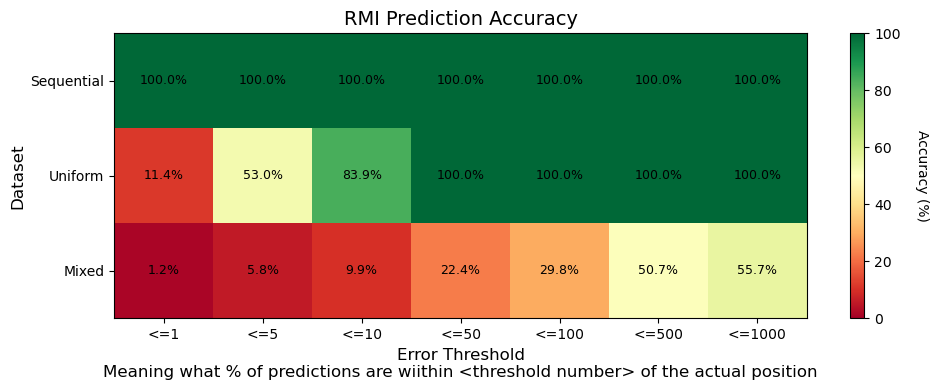

In [13]:
def heatmap():
    # Data
    datasets = {
        'Sequential': DatasetGenerator.generate_sequential(DATASET_SIZE),
        'Uniform': DatasetGenerator.generate_uniform(DATASET_SIZE),
        'Mixed': DatasetGenerator.generate_mixed(DATASET_SIZE)
    }

    thresholds = [1, 5, 10, 50, 100, 500, 1000]

    # Build the matrix
    matrix = np.zeros((len(datasets), len(thresholds)))

    # Go through each dataset and get their accuracy
    for i, (name, data) in enumerate(datasets.items()):

        # Build the index
        rmi = RecursiveModelIndex()
        rmi.build_from_sorted_array(data)

        # Get the predictions from the index (arrange for evently spaced)
        actual_positions = np.arange(len(data))
        predicted_positions = np.array([rmi.predict(key) for key in data])

        # Get the error
        errors = np.abs(predicted_positions - actual_positions)

        # Now, we can find the accuracy since we have the error
        for j, threshold in enumerate(thresholds):
            accuracy = np.sum(errors <= threshold) / len(errors) * 100
            matrix[i, j] = accuracy

        
    # Generate the heatmap now that we have the data
    fig, ax = plt.subplots(figsize=(10, 4))
    image = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

    # Set ticks and labels
    ax.set_xticks(np.arange(len(thresholds)))
    ax.set_yticks(np.arange(len(datasets)))
    ax.set_xticklabels([f'<={t}' for t in thresholds])
    ax.set_yticklabels(datasets.keys())
    
    # Add text annotations
    for i in range(len(datasets)):
        for j in range(len(thresholds)):
            text = ax.text(j, i, f'{matrix[i, j]:.1f}%',
                          ha="center", va="center", color="black", fontsize=9)
    
    ax.set_xlabel('Error Threshold\nMeaning what % of predictions are wiithin <threshold number> of the actual position', fontsize=12)
    ax.set_ylabel('Dataset', fontsize=12)
    ax.set_title('RMI Prediction Accuracy', fontsize=14)
    
    # Add colorbar
    cbar = plt.colorbar(image, ax=ax)
    cbar.set_label('Accuracy (%)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()

heatmap()

### Results from the accuracy plot:

### We can read this plot as in the threshold number being the amount of positions away it is from the correct position. For example, the RMI on the uniform dataset for <= 10 threshold correctly predicted 82.1% of the time within 10 positions. 
### In terms of the direct results, we can clearly see that the RMI struggles on the mixed data as the data is not uniform; but, not nearly as much as the learned index and linear adaptive index.

## This section will show the time performance metrics for all the indexes X datasets

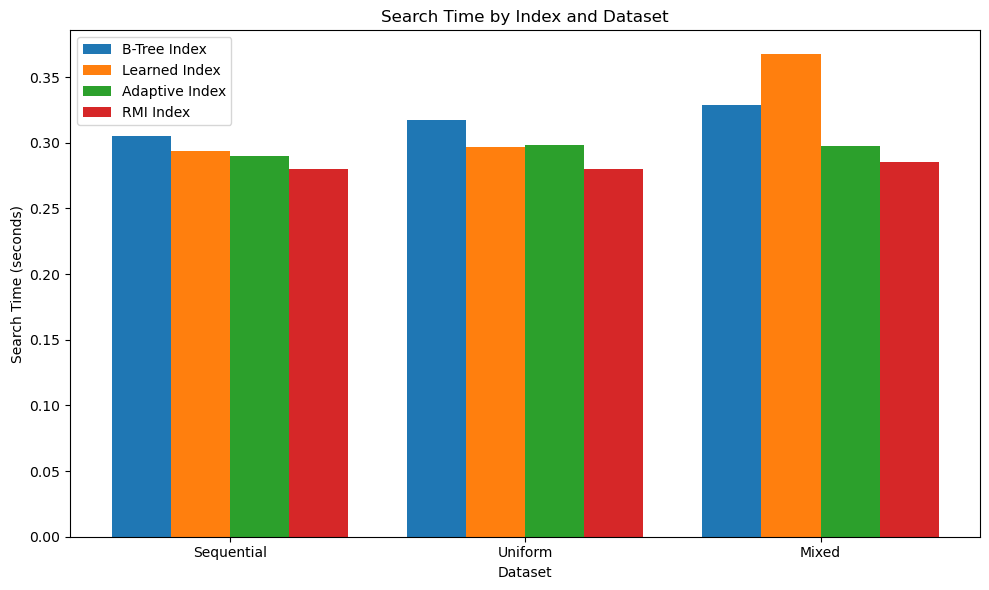

In [18]:
def time_plot():
    # Data
    datasets = {
        'Sequential': DatasetGenerator.generate_sequential(DATASET_SIZE),
        'Uniform': DatasetGenerator.generate_uniform(DATASET_SIZE),
        'Mixed': DatasetGenerator.generate_mixed(DATASET_SIZE)
    }

    # Indexes
    b_tree = BTree()
    learned_index = LearnedIndex()
    adaptive_index = LinearIndexAdaptive()
    rmi_index = RecursiveModelIndex()

    results = []

    for name, data in datasets.items():
        # Construct indexes
        b_tree.build_from_sorted_array(data)
        learned_index.build_from_sorted_array(data)
        adaptive_index.build_from_sorted_array(data)
        rmi_index.build_from_sorted_array(data)

        start = time.perf_counter()
        for key in data:
            b_tree.search(key)
        btree_time = time.perf_counter() - start

        # Time predictions
        start = time.perf_counter()
        for key in data:
            learned_index.search(key, data)
        learned_time = time.perf_counter() - start

        start = time.perf_counter()
        for key in data:
            adaptive_index.search(key, data)
        adaptive_time = time.perf_counter() - start

        start = time.perf_counter()
        for key in data:
            rmi_index.search(key)
        rmi_time = time.perf_counter() - start

        results.append((name, btree_time, learned_time, adaptive_time, rmi_time))

    # Plot the results now that we have the tital times (grouped bar chart)
    x_labels = np.arange(len(datasets))
    width = 0.2
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x_labels - 1.5*width, [r[1] for r in results], width, label='B-Tree Index')
    ax.bar(x_labels - 0.5*width, [r[2] for r in results], width, label='Learned Index')
    ax.bar(x_labels + 0.5*width, [r[3] for r in results], width, label='Adaptive Index')
    ax.bar(x_labels + 1.5*width, [r[4] for r in results], width, label='RMI Index')

    ax.set_xlabel('Dataset')
    ax.set_ylabel('Search Time (seconds)')
    ax.set_title('Search Time by Index and Dataset')
    ax.set_xticks(x_labels)
    ax.set_xticklabels([r[0] for r in results])
    ax.legend()
    plt.tight_layout()
    plt.show()

time_plot()